# 통신사 고객의 가입 해지 여부 예측 모델

## 데이터
- gender(성별)<br>
    Whether the customer is a male or a female


- SeniorCitizen(고령자 여부)<br>
    Whether the customer is a senior citizen or not (1, 0)


- Partner(배우자 유무)<br>
    Whether the customer has a partner or not (Yes, No)


- Dependents(부양가족 유무)<br>
    Whether the customer has dependents or not (Yes, No)


- tenure(근속월수)<br>
    Number of <strong>months</strong> the customer has stayed with the company


- PhoneService(휴대폰 유무)<br>
    Whether the customer has a phone service or not (Yes, No)


- MultipleLines(휴대폰 2개 이상 여부)<br>
    Whether the customer has multiple lines or not (Yes, No, No phone service)


- InternetService(인터넷 이용 여부 + 종류)<br>
    Customer’s internet service provider (DSL, Fiber optic, No)


- OnlineSecurity(보안 설정 여부)<br>
    Whether the customer has online security or not (Yes, No, No internet service)
    
    
- OnlineBackup(온라인 백업 여부)<br>
    Whether the customer has online backup or not (Yes, No, No internet service)

 
- DeviceProtection(단말기 보안 설정 여부)<br>
    Whether the customer has device protection or not (Yes, No, No internet service)


- TechSupport(기술 지원 여부)<br>
    Whether the customer has tech support or not (Yes, No, No internet service)


- StreamingTV(TV 시청 여부) <br>
    Whether the customer has streaming TV or not (Yes, No, No internet service)


- StreamingMovies(영화 시청 여부) <br>
    Whether the customer has streaming movies or not (Yes, No, No internet service)


- Contract(약정 기간) <br>
    The contract term of the customer (Month-to-month, One year, Two year)


- PaperlessBilling(디지털 청구서 수신 여부) <br>
    Whether the customer has paperless billing or not (Yes, No)


- PaymentMethod(결제 방식)<br>
    The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))


- MonthlyCharges(월 지불 금액)  <br>
    The amount charged to the customer monthly


- TotalCharges(지불할 총 금액) <br>
    The total amount charged to the customer


- Churn (가입 해지 여부)<br>
    Whether the customer churned or not (Yes or No)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        main_df = pd.read_csv(os.path.join(dirname, filename))

#         result_df = pd.read_csv(os.path.join(dirname, filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


------------------------------
YES or NO 답변이 많다보니 object 타입이 많다. <br>
타입 변환이 필요해보인다.<br><br>



In [4]:
main_df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

----------------
nunique값을 보니 Yes, No 형식이 제대로 맞춰져있나보다. (ex) YeS,YES,no,no phone service 이런식으로 되어 있는게 없다)

In [5]:
main_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 전처리

## 총지불금액(TotalCharges) -> float

In [6]:
main_df['TotalCharges'] = main_df['TotalCharges'].replace(' ','0').astype(float) 


In [7]:
main_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
main_df.loc[main_df.TotalCharges == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


-----------------
TotalCharges가 누락된 고객명단 -> contract를 참고해서 예측값을 넣자

## Contract -> int

In [9]:
dic = {'Month-to-month':1, 'One year':12, 'Two year': 24} 
for c in main_df.Contract.unique():
    main_df.Contract.replace(c,dic[c], inplace = True)

## TotalCharges 누락값 계산 : MonthlyCharges * Contract

In [10]:
#TotalCharges가 0인 고객 예측값    
main_df['TotalCharges'].replace(0.0,main_df['MonthlyCharges']*main_df['Contract'], inplace = True)

In [11]:
main_df.loc[main_df.TotalCharges == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


-------------------
이제 모든 고객의 TotalCharges가 채워졌다.

In [12]:
main_df.TotalCharges.describe()

count    7043.000000
mean     2281.253259
std      2265.703526
min        18.800000
25%       401.900000
50%      1396.250000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(main_df.TotalCharges)
plt.xlabel("TotalCharges")
plt.title("Distribution of TotalCharges")
plt.show()

In [ ]:
main_df.TotalCharges.nunique()

-----------
그런데 값의 분포가 너무 넓어서 binning을 수행해야할 것 같다.

In [ ]:
tmp_min = main_df.TotalCharges.min() #최솟값
tmp_max = main_df.TotalCharges.max() #최댓값
tmp_mean = main_df.TotalCharges.mean() #평균
bins = [tmp_min-1,tmp_mean/7,tmp_mean/2,tmp_mean,tmp_max/2,tmp_max] #최소~평균/7,평균/7~평균/2,평균/2 ~평균,평균~최대/2,최대/2~최대 
bins

In [ ]:
main_df['TotalCharges_bin'] = pd.cut(main_df.TotalCharges, bins, labels = list(range(len(bins)-1)))
main_df['TotalCharges_bin'].head()

In [ ]:
main_df.TotalCharges_bin.value_counts()

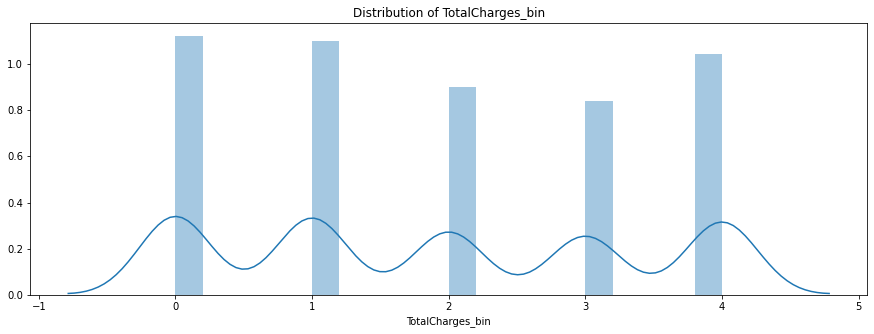

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(main_df.TotalCharges_bin)
plt.xlabel("TotalCharges_bin")
plt.title("Distribution of TotalCharges_bin")
plt.show()

------------------
5개의 그룹을 생성하여 분포의 범위를 줄였고, 그룹당 구성원 수도 비슷하게 맞추었다. 

## object -> category

In [19]:
main_df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6541
Churn                  2
TotalCharges_bin       5
dtype: int64

In [20]:
# from sklearn.preprocessing import LabelEncoder
# Encoder = LabelEncoder()
# for c in filter(lambda x: (main_df[x].dtype == 'O' and main_df[x].nunique() <=4 and x!='Churn') or x=='SeniorCitizen', main_df.columns):
#     main_df[c]= Encoder.fit_transform(main_df[c])

In [21]:
for c in filter(lambda x: (main_df[x].dtype == 'O' and main_df[x].nunique() <=4) or x=='SeniorCitizen', main_df.columns):
    main_df[c] = main_df[c].astype("category")

In [22]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   int64   
 16  PaperlessBilling  7043 n

In [23]:
main_df.describe()

,tenure,Contract,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,8.835865,64.761692,2281.253259
std,24.559481,9.551444,30.090047,2265.703526
min,0.000000,1.000000,18.250000,18.800000
25%,9.000000,1.000000,35.500000,401.900000
50%,29.000000,1.000000,70.350000,1396.250000
75%,55.000000,12.000000,89.850000,3786.600000
max,72.000000,24.000000,118.750000,8684.800000


--------------------------------
customerID를 제외한 모든 object타입을 적절한 타입으로 변환시켰다.

# EDA

## TotalCharges와 Churn의 상관관계는?

No     3001
Yes    1393
Name: Churn, dtype: int64
No     2173
Yes     476
Name: Churn, dtype: int64
No     871
Yes    708
Name: Churn, dtype: int64
No     1254
Yes     213
Name: Churn, dtype: int64


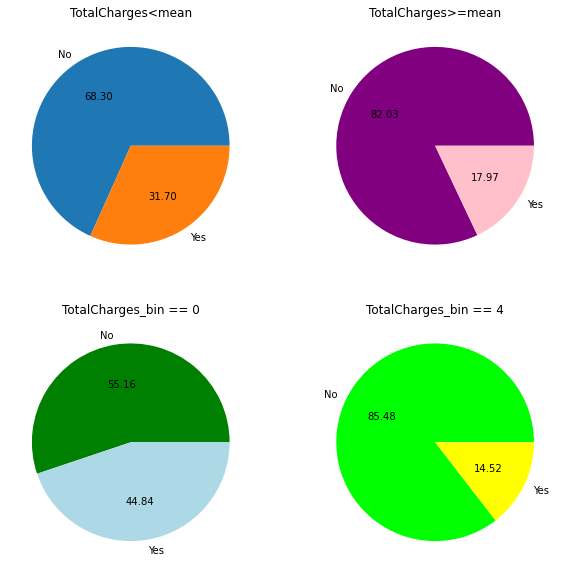

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("TotalCharges<mean")
print(main_df.loc[main_df.TotalCharges<tmp_mean].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges<tmp_mean].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'])
plt.subplot(2,2,2)
plt.title("TotalCharges>=mean")
print(main_df.loc[main_df.TotalCharges>=tmp_mean].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges>tmp_mean].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=['purple', 'pink'])
plt.subplot(2,2,3)
plt.title("TotalCharges_bin == 0")
print(main_df.loc[main_df.TotalCharges_bin==0].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges_bin==0].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=['green', 'lightblue'])
plt.subplot(2,2,4)
plt.title("TotalCharges_bin == 4")
print(main_df.loc[main_df.TotalCharges_bin==4].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges_bin==4].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=['lime', 'yellow'])
plt.show()

--------------------
위 결과를 보았을 때 TotalCharges이 높은 고객은 확실히 해지율이 낮다.<br><br>
그리고 그 차이는 양 끝단(TotalCharges가 아주 낮거나 아주 높을 때)에서 더 확연하다.

## Tenure과 Churn의 상관관계는?

No     2315
Yes    1460
Name: Churn, dtype: int64
No     2859
Yes     409
Name: Churn, dtype: int64


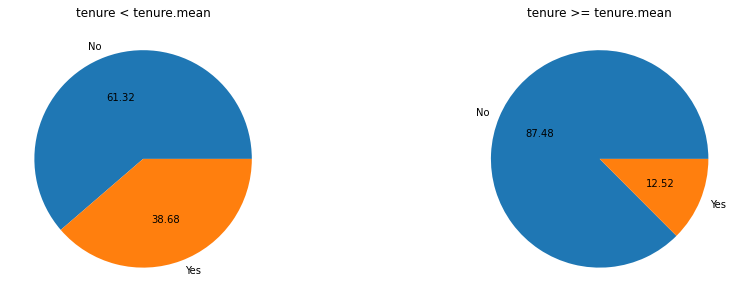

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("tenure < tenure.mean")
print(main_df.loc[main_df.tenure<main_df.tenure.mean()].Churn.value_counts())
plt.pie(main_df.loc[main_df.tenure<main_df.tenure.mean()].Churn.value_counts(), labels=['No','Yes'],autopct="%.2f")
plt.subplot(1,2,2)
plt.title("tenure >= tenure.mean")
print(main_df.loc[main_df.tenure>=main_df.tenure.mean()].Churn.value_counts())
plt.pie(main_df.loc[main_df.tenure>=main_df.tenure.mean()].Churn.value_counts(), labels=['No','Yes'],autopct="%.2f")

plt.show()

---------------------------
평균을 기준으로 근속월수가 높은 사람이 낮은 사람보다 해지 않을 확률이 훨씬 높다.

## Contract과 Churn의 상관관계는?

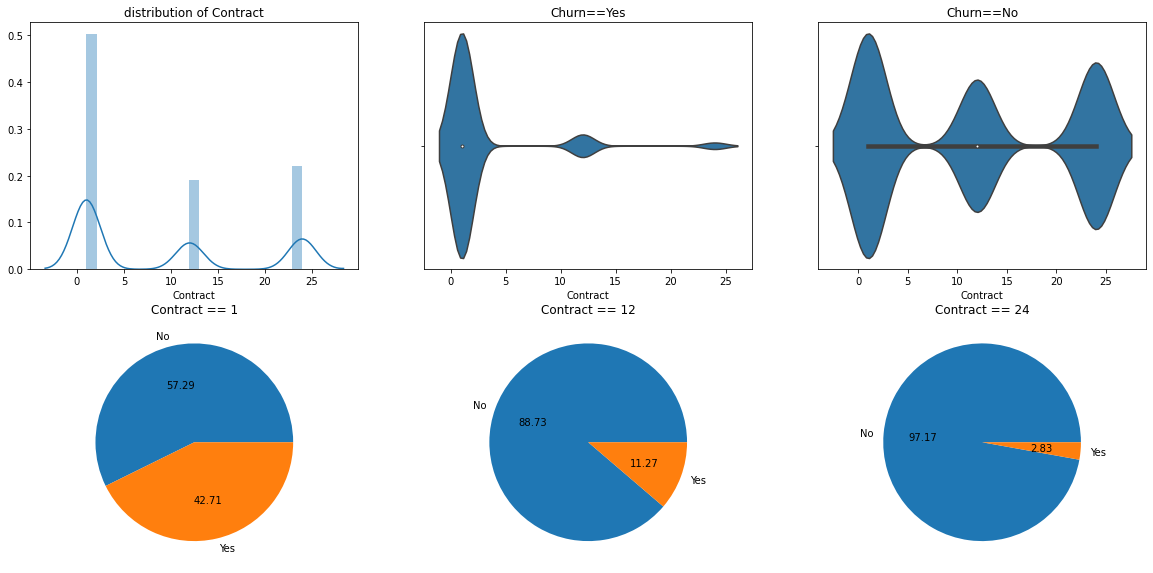

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title("distribution of Contract")
sns.distplot(main_df.Contract)

plt.subplot(2,3,2)
plt.title("Churn==Yes")
sns.violinplot(main_df.loc[main_df.Churn=='Yes'].Contract)

plt.subplot(2,3,3)
plt.title("Churn==No")
sns.violinplot(main_df.loc[main_df.Churn=='No'].Contract)

for e,month in enumerate([1,12,24],4):
    plt.subplot(2,3,e)
    plt.title(f"Contract == {month}")
    plt.pie(main_df.loc[main_df.Contract==month].Churn.value_counts(), autopct="%.2f", labels = main_df.loc[main_df.Contract==month].Churn.value_counts().keys())

plt.show()

--------------
위 결과에 따라 Contract가 높을수록 해지율이 낮아지는 것을 확인할 수 있다.

## 디지털 친화도(familiar_with_digital)와 Churn의 상관관계는?
    - 디지털 친화도 측정 방법: 백업, 보안, 다양한 서비스 이용여부 등 정보를 활용

In [27]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   int64   
 16  PaperlessBilling  7043 n

In [28]:
main_df.iloc[:,6:15]

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No,No phone service,DSL,No,Yes,No,No,No,No
1,Yes,No,DSL,Yes,No,Yes,No,No,No
2,Yes,No,DSL,Yes,Yes,No,No,No,No
3,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,Yes,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...
7038,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,No,No phone service,DSL,Yes,No,No,No,No,No
7041,Yes,Yes,Fiber optic,No,No,No,No,No,No


------------------
위 9개 서비스 이용을 많이할수록 디지털 친화도가 높다고 판단한다.

In [29]:
'''
DSL,Fiber optic, No Phone service 등 다양한 응답이 있으므로 
공백을 기준으로 split을 수행하고 첫번째 요소가 'No'만 아니면 친화도를 높인다(return 1)
'''

def count_digital(x):
    return  1 if x.split()[0]!='No' else 0

count_dig = [0 for _ in range(len(main_df))]
for e in range(6,15):
    for ind in range(len(main_df)):
        count_dig[ind] += count_digital(main_df.iloc[ind,e])
        
#디지털 친화도 컬럼 추가
main_df['familiar_with_digital'] = count_dig
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,1,Yes,Electronic check,29.85,29.85,No,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,12,No,Mailed check,56.95,1889.50,No,2,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,1,Yes,Mailed check,53.85,108.15,Yes,0,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,12,No,Bank transfer (automatic),42.30,1840.75,No,2,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,1,Yes,Electronic check,70.70,151.65,Yes,0,2


In [30]:
main_df.familiar_with_digital.describe()

count    7043.000000
mean        4.146244
std         2.312720
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: familiar_with_digital, dtype: float64

mean: 4
No     1719
Yes     404
Name: Churn, dtype: int64
No     2185
Yes     784
Name: Churn, dtype: int64
No     3455
Yes    1465
Name: Churn, dtype: int64
No     2989
Yes    1085
Name: Churn, dtype: int64


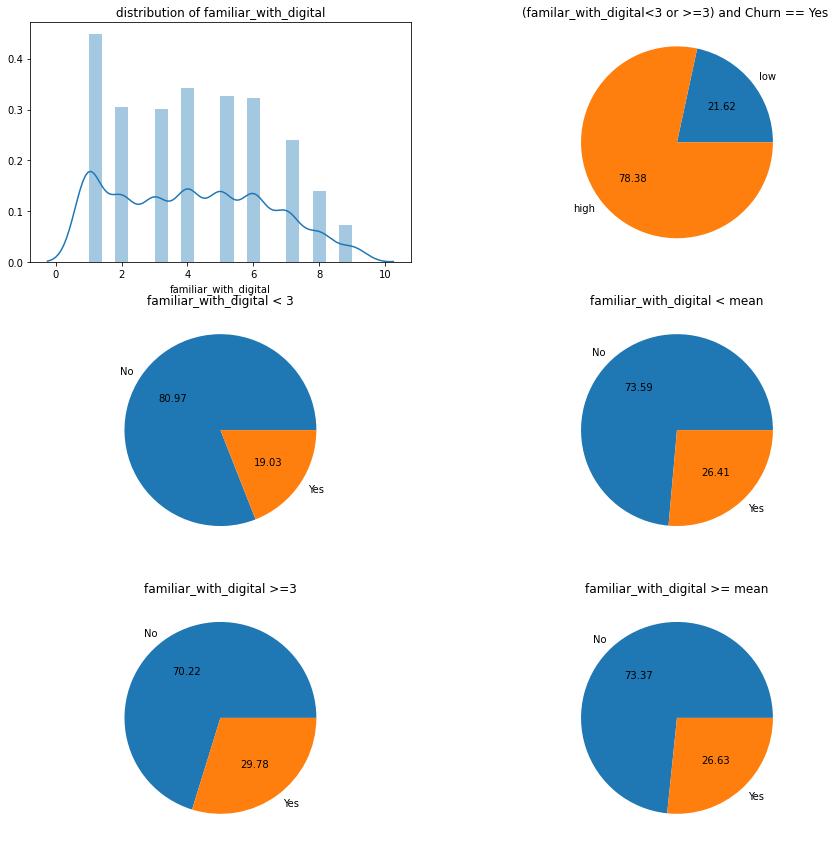

In [31]:
dig_mean = int(main_df.familiar_with_digital.mean())
print(f"mean: {dig_mean}")

plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.title("distribution of familiar_with_digital")
sns.distplot(main_df.familiar_with_digital)

plt.subplot(3,2,2)
plt.title("(familar_with_digital<3 or >=3) and Churn == Yes ")
plt.pie([main_df.loc[(main_df.familiar_with_digital<3) & (main_df.Churn == 'Yes')].customerID.count(),
         main_df.loc[(main_df.familiar_with_digital>=3) & (main_df.Churn == 'Yes')].customerID.count()],
        labels=['low', 'high'],autopct = "%.2f")

plt.subplot(3,2,3)
print(main_df.loc[main_df.familiar_with_digital <3].Churn.value_counts())
plt.title("familiar_with_digital < 3")
plt.pie(main_df.loc[main_df.familiar_with_digital < 3].Churn.value_counts(),autopct="%.2f",labels=["No","Yes"])



plt.subplot(3,2,4)
print(main_df.loc[main_df.familiar_with_digital <dig_mean].Churn.value_counts())
plt.title("familiar_with_digital < mean")
plt.pie(main_df.loc[main_df.familiar_with_digital < dig_mean].Churn.value_counts(),autopct="%.2f",labels=["No","Yes"])

plt.subplot(3,2,5)
print(main_df.loc[main_df.familiar_with_digital>=3].Churn.value_counts())
plt.title("familiar_with_digital >=3")
plt.pie(main_df.loc[main_df.familiar_with_digital >=3].Churn.value_counts(),autopct="%.2f",labels=["No","Yes"])


plt.subplot(3,2,6)
print(main_df.loc[main_df.familiar_with_digital >= dig_mean].Churn.value_counts())
plt.title("familiar_with_digital >= mean")
plt.pie(main_df.loc[main_df.familiar_with_digital >= dig_mean].Churn.value_counts(),autopct="%.2f",labels=["No",'Yes'])
plt.show()

----------------------------
디지털 친화도의 평균은 4이다. <br>
평균을 기준으로 비교를 했을 때보다 3을 기준으로 비교했을 때 더 뚜렷한 차이를 볼 수 있다.<br>
그런데 해지한 사람 중 디지털 친화도가 높은사람의 비율이 높다. 그리고 디지털 친화도가 높은 사람의 해지비율이 더 높다. 

## 수치형 컬럼들의 상관관계

In [32]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   customerID             7043 non-null   object  
 1   gender                 7043 non-null   category
 2   SeniorCitizen          7043 non-null   category
 3   Partner                7043 non-null   category
 4   Dependents             7043 non-null   category
 5   tenure                 7043 non-null   int64   
 6   PhoneService           7043 non-null   category
 7   MultipleLines          7043 non-null   category
 8   InternetService        7043 non-null   category
 9   OnlineSecurity         7043 non-null   category
 10  OnlineBackup           7043 non-null   category
 11  DeviceProtection       7043 non-null   category
 12  TechSupport            7043 non-null   category
 13  StreamingTV            7043 non-null   category
 14  StreamingMovies        7043 non-null   c

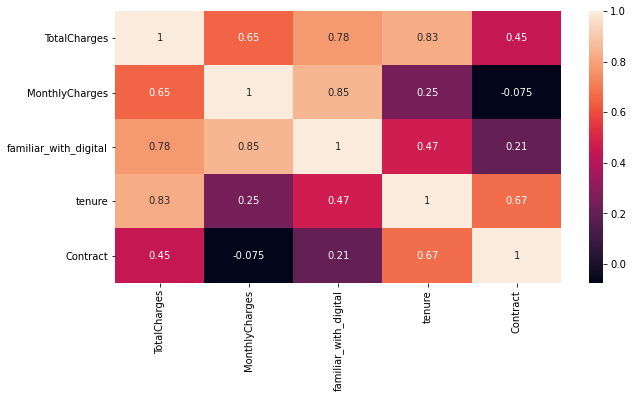

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(main_df[['TotalCharges', 'MonthlyCharges', 'familiar_with_digital','tenure','Contract']].corr(), annot=True)
plt.show()

-------------
양의 관계) *0.5이상
- familiar_with_digital 과 TotalCharges
- familiar_with_digital 과 MonthlyCharges
- tenure 과 TotalCharges
- tenure 과 Contract
- MonthlyCharges와 TotalCharges

## gender와 Churn의 상관관계는?

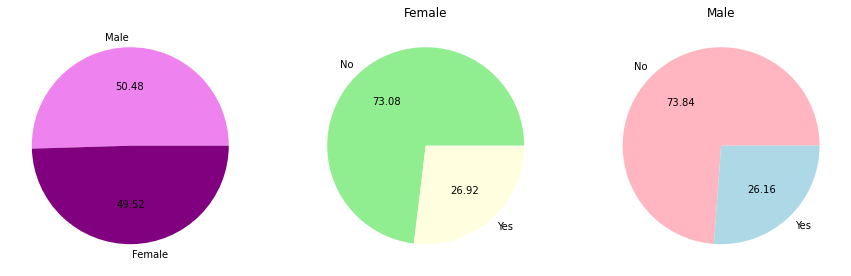

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pie(main_df.gender.value_counts(), autopct="%.2f", labels =main_df.gender.value_counts().keys(),colors = ['violet', 'purple'])
#남녀 Yes/No 비율
fe = main_df.loc[main_df.gender=='Female']
ma = main_df.loc[main_df.gender=='Male']
plt.subplot(1,3,2)
plt.title("Female")
plt.pie(fe.Churn.value_counts(), labels = fe.Churn.value_counts().keys(), autopct = "%.2f", colors =['lightgreen', 'lightyellow'])
plt.subplot(1,3,3)
plt.title("Male")
plt.pie(ma.Churn.value_counts(), labels = ma.Churn.value_counts().keys(), autopct = "%.2f", colors =['lightpink', 'lightblue'])
plt.show()

------------
성비가 비슷하고, 성별로 계약 해지여부 비율도 비슷하다

In [35]:
pd.pivot_table(main_df, index=['gender','Churn'])

Contract  MonthlyCharges  TotalCharges  familiar_with_digital  \
gender Churn                                                                   
Female No     11.200863       61.664908   2591.628737               4.224009   
       Yes     2.417465       74.812087   1440.979499               4.074547   
Male   No     11.002286       60.876914   2513.477390               4.123810   
       Yes     2.719355       74.066989   1623.491559               4.068817   

                 tenure  
gender Churn             
Female No     37.858768  
       Yes    17.004260  
Male   No     37.289524  
       Yes    18.963441

--------------------------
성별에 상관없이 해지를 하지 않은 사람들은 해지한 사람들에 비해 모두 계약기간이 길고, 
<br>
월지불금액과 총지불금액이 모두 높다 그리고 근속월수도 길다. 
<br>
디지털 친화도는 다 비슷해서 큰 의미가 없는 것 같다.

## SeniorCitizen과 Churn의 상관관계는?

* 우선, SeniorCitizen의 나이 기준은 정해진 것이 없는데, 대부분 약 60대부터 해당된다고 한다.  참고: https://www.seniorliving.org/life/senior-citizen/
 <br><br>->The age of a senior citizen varies according to the source. For example, according to Medicare, a senior is 65 years old or older. However, Social Security benefits are eligible for seniors starting at 62, even though the Social Security Office reports that 67 is the age of retirement. Yet if you are 55 and you visit an Arby’s or McDonald’s you can get a senior discount. By the way, Burger King requires you to be at least 60.

In [36]:
main_df.loc[main_df.SeniorCitizen == 1]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,No,Yes,1,Yes,Electronic check,39.65,39.65,Yes,0,3
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,No,No,24,Yes,Credit card (automatic),96.35,6766.95,No,4,7
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,...,Yes,Yes,1,Yes,Credit card (automatic),95.50,181.65,No,0,5
34,3413-BMNZE,Male,1,No,No,1,Yes,No,DSL,No,...,No,No,1,No,Bank transfer (automatic),45.25,45.25,No,0,2
50,8012-SOUDQ,Female,1,No,No,43,Yes,Yes,Fiber optic,No,...,Yes,No,1,Yes,Electronic check,90.25,3838.75,No,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023,1035-IPQPU,Female,1,Yes,No,63,Yes,Yes,Fiber optic,No,...,Yes,Yes,1,Yes,Electronic check,103.50,6479.40,No,4,7
7029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,...,Yes,Yes,1,Yes,Electronic check,44.40,263.05,No,0,3
7031,3605-JISKB,Male,1,Yes,No,55,Yes,Yes,DSL,Yes,...,No,No,12,No,Credit card (automatic),60.00,3316.10,No,3,5
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,1,Yes,Electronic check,75.75,75.75,Yes,0,3


In [37]:
pd.pivot_table(main_df, index=['SeniorCitizen'])

,Contract,MonthlyCharges,TotalCharges,familiar_with_digital,tenure
SeniorCitizen,,,,,
0,9.432977,61.847441,2178.836714,4.026097,32.192171
1,5.750438,79.820359,2810.465193,4.767075,33.295972


---------------
SeniorCitizen인 사람들(1)이 그렇지 않은 사람들(0)보다 계약기간은 짧지만 더 높은 금액을 지불하고 있고, 근속월수와 디지털 친화도가 더 높다.

In [38]:
main_df.loc[main_df.SeniorCitizen==1].Churn.value_counts()

No     666
Yes    476
Name: Churn, dtype: int64

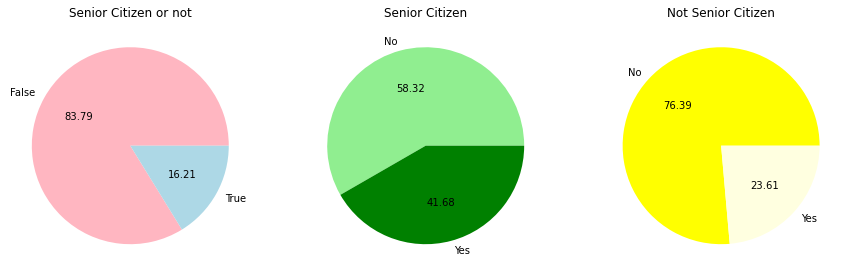

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Senior Citizen or not")
plt.pie(main_df.SeniorCitizen.value_counts(), autopct = "%.2f",labels = ['True'if k==1 else 'False' for k in main_df.SeniorCitizen.value_counts().keys()], 
        colors =['lightpink','lightblue'])
plt.subplot(1,3,2)
plt.title("Senior Citizen")
plt.pie(main_df.loc[main_df.SeniorCitizen==1].Churn.value_counts(), autopct = "%.2f",labels = main_df.loc[main_df.SeniorCitizen==1].Churn.value_counts().keys(), 
        colors =['lightgreen','green'])
plt.subplot(1,3,3)
plt.title("Not Senior Citizen")
plt.pie(main_df.loc[main_df.SeniorCitizen==0].Churn.value_counts(), autopct = "%.2f",labels = main_df.loc[main_df.SeniorCitizen==0].Churn.value_counts().keys(), 
        colors =['yellow','lightyellow'])
plt.show()

---------------
Senior Citizen은 전체 고객의 16.21%에 해당하고, 이들 중 해지한 사람은 41.68%이다.<br>
Senior Citizen이 아닌 사람들 중 해지한 사람은 23.61%이다.


위 자료를 보았을 때, Senior Citizen고객들은 비교적 짧은 계약기간, 높은 지불 금액, 장기 근속 월수, 높은 디지털 친화도라는 특징을 갖고 있다. <br>
다른 자료를 보았을 땐 지불 금액이 높고, 근속 월수가 길고, 계약기간이 길수록 해지율이 낮았다.<br> 
여기서 긴 계약기간을 제외하고는 모든 조건을 충족했지만(평균적으로), 해지율은 Senior citizen이 아닌 사람에 비해 높은 편이다.<br>
그래서 Senior Citizen인 경우 다른 컬럼들이 무의미할 정도로 해지여부에 큰 영향을 끼칠 수 있을 것이란 생각이 든다.

## Partner와 Churn의 상관관계

In [40]:
main_df.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [41]:
pd.pivot_table(main_df, index=['Partner'])

,Contract,MonthlyCharges,TotalCharges,familiar_with_digital,tenure
Partner,,,,,
No,6.120022,61.945001,1584.631310,3.708871,23.357869
Yes,11.742504,67.776264,3026.814844,4.614345,42.017637


--------
배우자가 있는 고객의 약정기간이 배우자가 없는 고객보다 더 길고, 더 많은 금액을 지불하고 있다. 그리고 디지털 친화도와 근속월수도 더 길다. 
<br>
*뭐든 다 높다.

In [42]:
pd.pivot_table(main_df,index= ['Partner','Churn'])

Contract  MonthlyCharges  TotalCharges  familiar_with_digital  \
Partner Churn                                                                   
No      No      8.170422       57.271856   1828.294244               3.683327   
        Yes     1.949167       71.450958   1088.980292               3.760833   
Yes     No     13.716795       64.831742   3198.343780               4.610684   
        Yes     3.677130       79.805232   2326.084529               4.629297   

                  tenure  
Partner Churn             
No      No     28.362966  
        Yes    13.176667  
Yes     No     45.793267  
        Yes    26.593423

----------------------
위 테이블을 보면, <br>
배우자유무에 상관없이, 해지한 고객에 비해 해지하지 않은 고객들이
1. 약정기간이 길고, 
2. 월지불금액은 낮지만 전체지불금액이 높고, 
3. 디지털친화도가 아주 조금 더 낮고, 
4. 근속월수가 길다.
<br><br>

*TotalCharges와 Churn의 상관관계 분석을 통해서는 TotalCharges가 높을 수록 Churn=='No'일 확률이 높다는 것을 알고 있었다. <br>
*다음엔 MonthlyCharges와 Churn의 상관관계를 분석해봐야겠다.
<br>

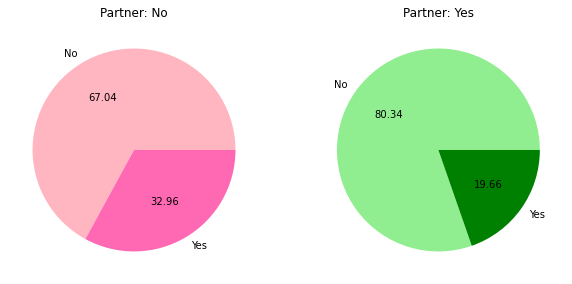

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Partner: No")
plt.pie(main_df.loc[main_df.Partner == 'No'].Churn.value_counts(),autopct = '%.2f',labels=main_df.loc[main_df.Partner == 'No'].Churn.value_counts().keys(),colors = ['lightpink','hotpink'])
plt.subplot(1,2,2)
plt.title("Partner: Yes")
plt.pie(main_df.loc[main_df.Partner == 'Yes'].Churn.value_counts(),autopct = '%.2f',labels=main_df.loc[main_df.Partner == 'Yes'].Churn.value_counts().keys(),colors = ['lightgreen', 'green'])
plt.show()

--------------------------------
배우자가 있는 사람보다 없는 사람의 해지비율이 더 높다.


## MonthlyCharges와 Churn의 상관관계

In [44]:
main_df.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

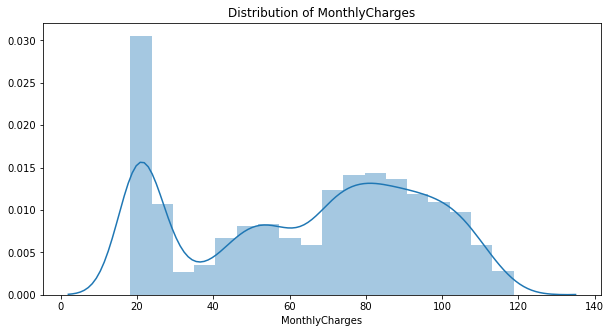

In [45]:
plt.figure(figsize=(10,5))
plt.title("Distribution of MonthlyCharges")
sns.distplot(main_df.MonthlyCharges)
plt.show()

--------------------------
MonthlyCharges의 값을 특정 구간으로 나눈 MonthlyCharges_bin이라는 컬럼을 하나 더 만들어서 살펴보자

- MonthlyCharges_bin

In [46]:
bins = [0]
for i in range(1,11,1):
    bins.append(main_df.MonthlyCharges.quantile(0.1*i))
main_df['MonthlyCharges_bin'] = pd.cut(main_df.MonthlyCharges, bins, labels = list(range(len(bins)-1)))
bins

[0,
 20.05,
 25.05,
 45.85,
 58.83000000000002,
 70.35,
 79.1,
 85.5,
 94.25,
 102.6,
 118.75]

In [47]:
main_df.MonthlyCharges_bin.value_counts()

0    717
4    711
6    705
9    704
8    704
1    703
7    702
3    702
5    700
2    695
Name: MonthlyCharges_bin, dtype: int64

--------------------
MonthlyCharges값을 백분율 10%단위로 끊어서 MonthlyCharges_bin컬럼을 만들어보았다. 

In [48]:
pd.pivot_table(main_df, index=['MonthlyCharges_bin', 'Churn'])

Contract  MonthlyCharges  TotalCharges  \
MonthlyCharges_bin Churn                                            
0                  No     12.875000       19.630335    557.844893   
                   Yes     2.475410       19.622131    154.021311   
1                  No     13.550473       21.792902    724.897555   
                   Yes     2.463768       22.000000    138.278261   
2                  No     10.206564       34.825000   1040.363900   
                   Yes     1.627119       38.300565    370.748870   
3                  No      7.209434       52.746698   1518.830943   
                   Yes     2.244186       51.949128    681.456977   
4                  No     10.428315       64.790502   2318.395878   
                   Yes     2.594771       67.425163    775.958824   
5                  No      8.921478       74.661085   2532.951155   
                   Yes     1.539326       74.693071    844.069663   
6                  No     11.036530       82.134132   3436.486187   
                   Yes     1.797753       82.210300   1332.217228   
7                  No      9.880694       89.854338   3976.488720   
                   Yes     1.975104       89.885477   1612.587137   
8                  No      9.651442       98.036418   4506.473077   
                   Yes     2.465278       98.065278   2534.344618   
9                  No     15.473585      108.744057   6473.682642   
                   Yes     7.643678      106.821839   4843.920690   

                          familiar_with_digital     tenure  
MonthlyCharges_bin Churn                                    
0                  No                  1.000000  28.304878  
                   Yes                 1.000000   7.786885  
1                  No                  1.288644  32.509464  
                   Yes                 1.086957   6.246377  
2                  No                  2.517375  31.162162  
                   Yes                 2.288136   9.988701  
3                  No                  3.898113  28.479245  
                   Yes                 3.482558  12.941860  
4                  No                  4.980287  35.965950  
                   Yes                 3.137255  11.849673  
5                  No                  4.896074  33.893764  
                   Yes                 3.161049  11.277154  
6                  No                  5.605023  41.815068  
                   Yes                 3.985019  16.168539  
7                  No                  5.995662  44.180043  
                   Yes                 4.751037  17.854772  
8                  No                  6.016827  45.860577  
                   Yes                 5.753472  25.715278  
9                  No                  7.788679  59.371698  
                   Yes                 7.356322  45.132184

In [49]:
tmp_df = pd.DataFrame({'MonthlyCharges_bin':[],'Churn rate':[]})
for i in range(10):
    target = main_df.loc[main_df.MonthlyCharges_bin == i].Churn.value_counts()
    tmp_df = tmp_df.append({'MonthlyCharges_bin':i,'Churn rate':round(target['Yes']/target.sum()*100,2)},ignore_index=True)

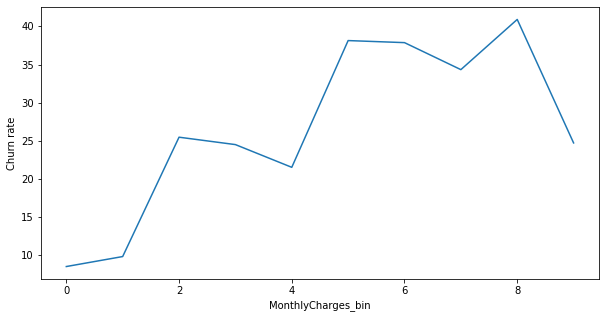

In [50]:
plt.figure(figsize=(10,5))
sns.lineplot(x=tmp_df['MonthlyCharges_bin'], y= tmp_df['Churn rate'])
plt.show()

-----------------
MonthlyCharges_bin의 값과 해지율이 선형적인 관계를 가질 줄 알았다.<br>
하지만 bin이 5-8인경우에 해지율이 가장 높고, bin이 0-1인경우 해지율이 가장 낮았다. 나머지는 20%대로 비슷하다.<br>
해당 컬럼도 충분히 의미 있을 수 있지만, 선형적인 관계를 만들어보고 싶기에 MonthlyCharges_bin2 컬럼을 만들어보기로 했다.

- MonthlyCharges_bin2

In [51]:
bins = [0,main_df.MonthlyCharges.quantile(.35),main_df.MonthlyCharges.quantile(.65),
        main_df.MonthlyCharges.quantile(1)]
bins

[0, 53.13499999999999, 81.45, 118.75]

In [52]:
main_df['MonthlyCharges_bin2'] = pd.cut(main_df.MonthlyCharges, bins, labels = list(range(len(bins)-1)))
main_df.MonthlyCharges_bin2.value_counts()

0    2465
2    2462
1    2116
Name: MonthlyCharges_bin2, dtype: int64

-------
0,백분율 35%의 값, 65%의 값, 최댓값을 구간의 경계값으로 설정했다. 각 구간에 속한 고객수는 2000대 초반~중반으로 맞추었다.


In [53]:
pd.pivot_table(main_df, index=['MonthlyCharges_bin2', 'Churn'])

Contract  MonthlyCharges  TotalCharges  \
MonthlyCharges_bin2 Churn                                            
0                   No     11.563107       27.808641    817.681699   
                    Yes     1.940741       35.414321    330.049012   
1                   No      9.659045       68.177236   2400.677707   
                    Yes     2.030207       71.798092    880.155087   
2                   No     11.830977       97.308175   4886.114167   
                    Yes     3.276647       95.361737   2605.556287   

                           familiar_with_digital     tenure  
MonthlyCharges_bin2 Churn                                    
0                   No                  1.773301  29.964078  
                    Yes                 2.091358   9.051852  
1                   No                  4.880968  35.015467  
                    Yes                 3.362480  12.451510  
2                   No                  6.564843  49.534726  
                    Yes                 5.566467  26.473054

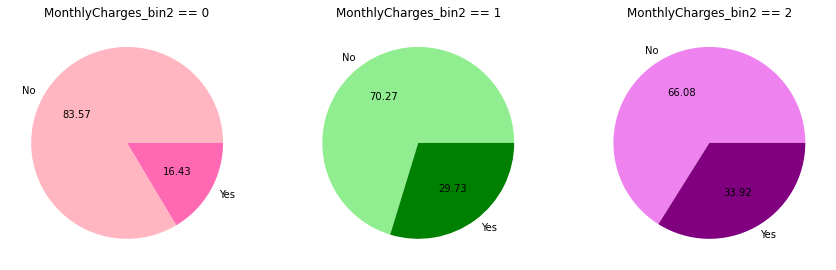

In [54]:
plt.figure(figsize=(20,15))
color_dic = {0:['lightpink','hotpink'],1:['lightgreen','green'],2:['violet','purple'],
             3:['lightgray','gray'],4:['lightyellow','yellow'],5:['#ff5050','#ffaa00'],
            6:['#ff99ff','#ff6699',],7:['#e6f2ff','#99ccff'],8:['#ccccff','#cc99ff'],
            9:['#ff9966', '#ff6600']}
for e in range(3):
    plt.subplot(3,4,e+1)
    target =main_df.loc[main_df.MonthlyCharges_bin2 == e].Churn.value_counts() 
    plt.pie(target, autopct="%.2f", labels =target.keys(),colors=color_dic[e])
    plt.title(f"MonthlyCharges_bin2 == {e}")
plt.show()


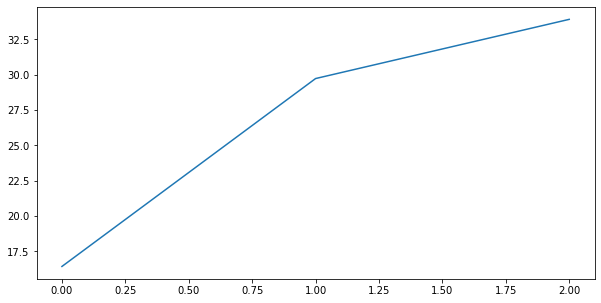

In [55]:
pct = {}
for i in range(3):
    target = main_df.loc[main_df.MonthlyCharges_bin2 == i].Churn.value_counts()
    pct[i] = round(target['Yes']/target.sum()*100,2)
plt.figure(figsize=(10,5))
sns.lineplot(x=list(range(3)), y=list(pct.values()))
plt.show()

-----------
이렇게 세구간으로 나누니 bin값이 커질수록 해지율이 높아지는 선형적인 관계를 가지게 되었다.<br>


In [56]:
main_df['MonthlyCharges_bin2']=main_df.MonthlyCharges_bin2.astype('int')

--------------------------------------------------------
따라서 MonthlyCharges_bin2값의 크기가 의미를 가지므로 category -> int로 형변환을 해주었다.

## Dependents와 Churn의 상관관계

In [57]:
main_df.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [58]:
pd.pivot_table(main_df, index=['Dependents'])

,Contract,MonthlyCharges,MonthlyCharges_bin2,TotalCharges,familiar_with_digital,tenure
Dependents,,,,,,
No,7.320089,67.002808,1.050274,2187.709254,4.155686,29.806000
Yes,12.379621,59.522156,0.881043,2499.951161,4.124171,38.368246


----------------------
부양가족이 있는 고객들이 없는 고객에 비해 약정기간이 길고, 월 지불 금액이 낮고 전체 지불 금액은 높다. 그리고 근속월수도 더 길다.


***->부양가족이 있는 고객들의 해지율이 낮을 것으로 예상한다***


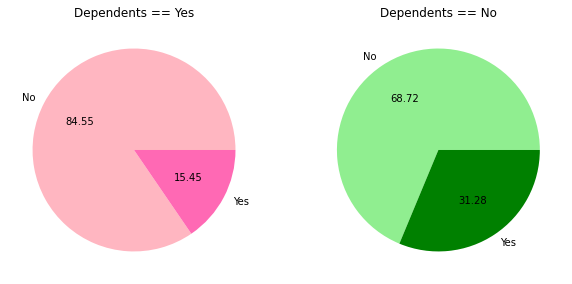

In [59]:
target_yes = main_df.loc[main_df.Dependents=='Yes'].Churn.value_counts()
target_yes = main_df.loc[main_df.Dependents=='No'].Churn.value_counts()
plt.figure(figsize=(10,10))
for e,ans in enumerate(['Yes','No']):
    plt.subplot(1,2,e+1)
    target= main_df.loc[main_df.Dependents==ans,'Churn'].value_counts()
    plt.pie(target, autopct='%.2f', labels=target.keys(),colors=color_dic[e])
    plt.title(f"Dependents == {ans}")

plt.show()

-----------------
예상대로 부양가족이 있는 고객들의 해지율이 더 낮다.

# 모델 적용 및 평가

- Feature Selection

In [60]:
feature_all = main_df.columns.drop(['Churn','customerID'])

In [61]:
#familiar_with_digital이 TotalCharges, MonthlyCharges와 높은 양의 관계를 가지므로 해당 컬럼 하나만 적용 
feature1 = ['Contract','familiar_with_digital', 'tenure'] 
feature2 =  ['Contract','familiar_with_digital', 'tenure','SeniorCitizen'] 
feature3,feature4 = feature2[:],feature2[:]
feature3.append('MonthlyCharges_bin')
feature4.append('MonthlyCharges_bin2')

------------------------------------------
위 분석을 토대로 피처선택

In [62]:
#수치화
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
for c in feature_all:
    main_df[c]= Encoder.fit_transform(main_df[c])

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
dt_clf = DecisionTreeClassifier()
svm_clf = svm.SVC(probability = True)
nb_clf = MultinomialNB()
log_clf = LogisticRegression()

def get_score(model, feature, custom_cv):
    model = model.lower()
    if model=='dt':
        return cross_val_score(dt_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()
    elif model == 'svm':
        return cross_val_score(svm_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()
    elif model == 'nb':
        return cross_val_score(nb_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()
    elif model == 'log':
        return cross_val_score(log_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()
    elif model == 'gb':
        return cross_val_score(gb_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()
    elif model == 'rf':
        return cross_val_score(rf_clf, main_df[feature],main_df['Churn'],cv=custom_cv).mean()

In [ ]:
names = ['RF','GB','DT','SVM','NB','LOG']
score_df = pd.DataFrame({'model':[], 'feature':[], 'score':[], 'cv': []})
for n in names:
    score_df = score_df.append({'model':n,'feature':'all','score':get_score(n,feature_all,10),'cv':10}, ignore_index=True)
    score_df = score_df.append({'model':n,'feature':'all','score':get_score(n,feature_all,10),'cv':10}, ignore_index=True)
score_df

In [ ]:
score_df

In [ ]:
# from sklearn.model_selection import GridSearchCV
# params = {'n_estimators': [i for i in range(10,100,15)], 'max_depth':[i for i in range(3,20,5)],
#          'min_samples_leaf':[i for i in range(5,20,5)], 'min_samples_split':[i for i in range(10,50,10)]}
# grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=6, n_jobs = -1, verbose=3)#n_jobs=-1: 모든 코어 사용,verbose: 로그출력 레벨 조정 
# grid_cv.fit(main_df[feature_all], main_df['Churn'])


In [ ]:
# print("최적 하이퍼 파라미터", grid_cv.best_params_)

In [ ]:

# print("최고 예측 정확도:{:.3f}".format(grid_cv.best_score_))

-----------------------------
# 앞으로 남은 일

- Senior와 Partner의 상관관계 분석
- familiar_with_digital 개선 (지금은 별 의미 없어 보임)
- 모두 수치화해서 모든 컬럼별 상관관계 분석
- familiar_with_digital에서 Charges랑 관련있는거 빼보기
- Grid search cv